<a href="https://colab.research.google.com/github/b-pinter/AI_Leaderboard/blob/main/Neanderthals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Uninstall Colab's bigframes because it conflicts with other installs
%pip uninstall -y bigframes
# Install Lightning, also let's use "rich" progress bars
%pip install -Uqq lightning wandb rich einops

ERROR: Operation cancelled by user


In [ ]:
import torch
from torch import nn, optim, utils
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, RandomAffine, RandomErasing
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
# Not advocating Lightning over raw pytorch, but it offers some useful abstractions
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import RichProgressBar
import wandb
import numpy as np
from einops import rearrange

In [ ]:
# optional: define additional data augmentation transformers for the dataloader
train_transforms = torchvision.transforms.Compose([
    ToTensor(),
    # uncomment next lines for extra augmentations
    #RandomAffine(degrees=15, translate=(0.1, 0.1)),
    #RandomErasing(p=0.2, scale=(0.02, 0.1))
])

train_ds = MNIST(root='./data', train=True,  download=True, transform=train_transforms)
test_ds  = MNIST(root='./data', train=False, download=True, transform=ToTensor())
val_ds = test_ds  #alias val for test
print(f"Data set lengths: train: {len(train_ds)}, test: {len(test_ds)}")



batch_size = 128   # could make this bigger; note for MNIST on Colab we're disk-speed limited, not GPU-limited
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=2, shuffle=True, persistent_workers=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=2, shuffle=False, persistent_workers=True)
val_dl = test_dl # alias val <--> test

Data set lengths: train: 60000, test: 10000


In [37]:
class SimpleVAEModel(L.LightningModule):
    def __init__(self,
                 latent_dim=3,    # dimensionality of the latent space. bigger=less compression, better reconstruction
                 n_hid=[256,64],  # simple
                 act = nn.LeakyReLU,
                 lr=1e-3
                 ):
        super().__init__()
        self.encoder = nn.Sequential(
                nn.Linear(28 * 28, n_hid[0]),act(),
                nn.Linear(n_hid[0], n_hid[1]), act(),
                nn.Linear(n_hid[1], latent_dim*2), # *2 b/c mu, log_var
                )
        self.decoder = nn.Sequential(
                nn.Linear(latent_dim, n_hid[1]), act(),
                nn.Linear(n_hid[1], n_hid[0]),  act(),
                nn.Linear(n_hid[0], 28 * 28)
                )
        self.latent_dim, self.n_hid, self.act, self.lr = latent_dim, n_hid, act, lr # save for possible use later
        self.save_hyperparameters()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten to (batch, 784)
        z = self.encoder(x)
        i_half = z.shape[-1]//2
        mu, log_var = z[:,:i_half],  z[:,i_half:]
        z_hat = mu + torch.randn_like(mu) * torch.exp(0.5*log_var)
        x_hat = self.decoder(z_hat)
        x_hat = x_hat.view(x_hat.size(0), 1, 28, 28)  # Reshape back for BCE loss
        return z, x_hat, mu, log_var, z_hat

    def training_step(self, batch, batch_idx):
        x, _ = batch
        z, x_hat, mu, log_var, z_hat = self(x)
        # Reconstruction loss (binary cross-entropy)
        recon_loss = F.binary_cross_entropy_with_logits(x_hat, x, reduction='sum')
        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + kl_loss
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


class SimpleFlowModel(nn.Module):
    def __init__(self, latent_dim=3, n_hidden=32, n_layers=3, act=nn.LeakyReLU):
        super(SimpleFlowModel, self).__init__()
        self.latent_dim = latent_dim
        self.layers = nn.Sequential(
            nn.Linear(latent_dim+1, n_hidden), act(),
            *[nn.Sequential(nn.Linear(n_hidden, n_hidden), act()) for _ in range(n_layers-1)],
            nn.Linear(n_hidden, latent_dim),)

    def forward(self, x, t, act=F.gelu):
        t = t.expand(x.size(0), 1)  # Ensure t has the correct dimensions
        x = torch.cat([x, t], dim=1)
        return self.layers(x)




### these next two are identical to blog post
@torch.no_grad()
def fwd_euler_step(model, current_points, current_t, dt):
    velocity = model(current_points, current_t)
    return current_points + velocity * dt

@torch.no_grad()
def integrate_path(model, initial_points, step_fn=fwd_euler_step, n_steps=100,
                   save_trajectories=False, warp_fn=None):
    """this 'sampling' routine is primarily used for visualization."""
    device = next(model.parameters()).device
    current_points = initial_points.clone()
    ts =  torch.linspace(0,1,n_steps).to(device)
    if warp_fn: ts = warp_fn(ts)
    if save_trajectories: trajectories = [current_points]
    for i in range(len(ts)-1):
        current_points = step_fn(model, current_points, ts[i], ts[i+1]-ts[i])
        if save_trajectories: trajectories.append(current_points)
    if save_trajectories: return current_points, torch.stack(trajectories).cpu()
    return current_points
#####




class SubmissionInterface(nn.Module):
    """All teams must implement this for automated evaluation.
    When you subclass/implement these methods, replace the NotImplementedError."""

    def __init__(self):
        super().__init__()

        #--- REQUIRED INFO:
        self.info = {
            'team': 'Neanderthals',  # REPLACE with your team name. This will be public
            'names': 'Brady, Kenneth, Max', # or single name. This will be kept private
        }
        self.latent_dim = 3   # TODO: we could just (re)measure this on the fly
        #----

        # keep support for full auto-initialization:
        self.load_vae()
        self.load_flow_model()
        self.device = 'cpu' # we can change this later via .to()

    def load_vae(self):
        """this completely specifies the vae model including configuration parameters,
           downloads/mounts the weights from Google Drive, automatically loads weights"""
        self.vae = SimpleVAEModel(latent_dim=self.latent_dim)
        vae_weights_file = 'downloaded_vae.safetensors'
        if not os.path.exists(vae_weights_file):
            safetensors_link = "https://drive.google.com/file/d/1N4VS3HKBrXnuQhiud1ruMTFZ5jbhsrIn/view?usp=sharing"
            gdown.download(safetensors_link, vae_weights_file, quiet=False, fuzzy=True)
        self.vae.load_state_dict(load_file(vae_weights_file))

    def load_flow_model(self):
        """this completely specifies the flow model including configuration parameters,
           downloads/mounts the weights from Google Drive, automatically loads weights"""
        self.flow_model = SimpleFlowModel(latent_dim=self.latent_dim)
        flow_weights_file = 'downloaded_flow.safetensors'
        if not os.path.exists(flow_weights_file):
            safetensors_link = "https://drive.google.com/file/d/13hlolKEc1QB6wA5M_sSgH8wfKR35fjc9/view?usp=sharing"
            gdown.download(safetensors_link, flow_weights_file, quiet=False, fuzzy=True)
        self.flow_model.load_state_dict(load_file(flow_weights_file))

    def generate_samples(self, n_samples:int, n_steps=100) -> torch.Tensor:
        z0 = torch.randn([n_samples, self.latent_dim]).to(self.device)
        z1 = integrate_path(self.flow_model, z0, n_steps=n_steps)
        gen_xhat = F.sigmoid(self.decode(z1).view(-1, 28, 28))
        return gen_xhat

    def encode(self, images: torch.Tensor) -> torch.Tensor:
        # if your vae has linear layers, flatten first
        # if your vae has conv layers, comment out next line
        images = images.view(images.size(0), -1)
        with torch.no_grad():
            z = self.vae.encoder(images.to(self.device))
            mu = z[:, :self.latent_dim]  # return only first half (mu)
            return mu

    def decode(self, latents: torch.Tensor) -> torch.Tensor:
        return self.vae.decoder(latents)

    def to(self, device):
        self.device = device
        self.vae.to(self.device)
        self.flow_model.to(self.device)
        return self


# Sample usage:
# device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
# mysub = SubmissionInterface().to(device) # loads vae and flow models
# xhat_gen = mysub.generate_samples(n_samples=10, n_steps=100)

In [38]:
vae = SimpleVAEModel()
model = vae

wandb.login()
wandb.finish()

wandb_logger = WandbLogger(log_model="all", project='vae_tut')
wandb_logger.watch(model) # this thing complains too much upon re-runs, just ignore it and keep going

epochs = 25  # VAEs require more steps to train than vanilla AEs, due to dual-objective loss
trainer = L.Trainer(max_epochs=epochs, devices="auto", logger=wandb_logger, callbacks=RichProgressBar(leave=True))
trainer.fit(model=vae, train_dataloaders=train_dl, val_dataloaders=val_dl)
wandb.finish()

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/configuration_validator.py:68: You pas

┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type       ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ encoder │ Sequential │  217 K │ train │
│ 1 │ decoder │ Sequential │  218 K │ train │
└───┴─────────┴────────────┴────────┴───────┘

Trainable params: 436 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 436 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 13                                                                                          
Modules in eval mode: 0

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO: `Trainer.fit` stopped: `max_epochs=25` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████
train_loss,███████▇▇█▇▇▆▇▇▇▇▇▆█▇█▇▇▇▇▆▆▆▆▆▅▅▆▅▃▃▃▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇██
epoch,24
train_loss,69287.36719
trainer/global_step,11699


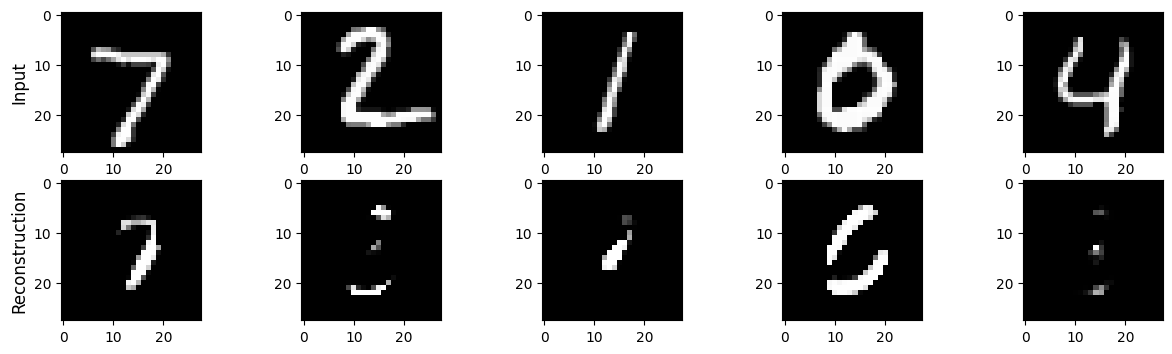

In [40]:
# @title `test_inference` visualization code
@torch.no_grad()
def test_inference(model, idx=None, return_fig=False):
    import inspect
    model.eval()
    if idx is None: idx = torch.randint(len(test_ds), (1,))[0]
    if isinstance(idx, int): idx = [idx]
    elif isinstance(idx, range): idx = list(idx)
    x_batch = torch.stack([test_ds[i][0] for i in idx]).to(model.device)  # images
    y_batch = torch.tensor([test_ds[i][1] for i in idx]).to(model.device) # labels
    # if not model.use_conv: # Removed this line as SimpleVAEModel does not have use_conv
    x_batch = x_batch.view(x_batch.size(0), -1)
    if 1==len(inspect.signature(model.forward).parameters): # for ae or vae
        result = model.forward(x_batch)
    else:                                                   # c-vae (later in lesson)
        cond = F.one_hot(y_batch, num_classes=10).float()
        result = model.forward(x_batch, cond)
    z, recon = result[:2]
    recon = torch.sigmoid(recon)       # normalize logits to [0,1]
    recon = recon.view(len(idx), 28, 28)
    fig, axs = plt.subplots(2, len(idx), figsize=(3*len(idx), 4))
    if len(idx) == 1: axs = axs.reshape(2, 1)
    for i in range(len(idx)):
        axs[0,i].imshow(x_batch[i].view(28,28).cpu(), cmap='gray')
        axs[1,i].imshow(recon[i].cpu(), cmap='gray')
        if i == 0:
            axs[0,0].set_ylabel('Input', fontsize=12)
            axs[1,0].set_ylabel('Reconstruction', fontsize=12)
    model.train()
    if return_fig: return fig
    plt.show()

idx = range(5)
test_inference(vae, idx=idx)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
neanderthal_sub = SubmissionInterface().to(device) # loads vae and flow models
xhat_gen = neanderthal_sub.generate_samples(n_samples=10, n_steps=100)

# Task
Train the VAE model without using the PyTorch Lightning Module.

## Define training function

### Subtask:
Create a function that performs one training epoch. This function will iterate over the training dataloader, perform the forward pass, calculate the loss (reconstruction loss and KL divergence), perform backpropagation, and update the model's weights.


**Reasoning**:
The goal is to create a function for a single training epoch of the VAE model. This involves iterating through the dataloader, performing the forward pass, calculating the loss components (reconstruction and KL divergence), and executing the optimization step. The provided code block will implement this function according to the instructions.

